
<a id='lssm'></a>

# Linear State Space Models


<a id='index-0'></a>

## Contents

- [Linear State Space Models](#Linear-State-Space-Models)  
  - [Overview](#Overview)  
  - [The Linear State Space Model](#The-Linear-State-Space-Model)  
  - [Distributions and Moments](#Distributions-and-Moments)  
  - [Stationarity and Ergodicity](#Stationarity-and-Ergodicity)  
  - [Noisy Observations](#Noisy-Observations)  
  - [Prediction](#Prediction)  
  - [Code](#Code)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

> “We may regard the present state of the universe as the effect of its past and the cause of its future” – Marquis de Laplace


In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!conda install -y quantecon

Solving environment: done

# All requested packages already installed.



## Overview

This lecture introduces the **linear state space** dynamic system.

The linear state space system is a generalization of the scalar AR(1) process [we studied before](https://python.quantecon.org/ar1_processes.html).

This model is a workhorse that carries a powerful theory of prediction.

Its many applications include:

- representing dynamics of higher-order linear systems  
- predicting the position of a system $ j $ steps into the future  
- predicting a geometric sum of future values of a variable like  
  - non-financial income  
  - dividends on a stock  
  - the money supply  
  - a government deficit or surplus, etc.  
- key ingredient of useful models  
  - Friedman’s permanent income model of consumption smoothing.  
  - Barro’s model of smoothing total tax collections.  
  - Rational expectations version of Cagan’s model of hyperinflation.  
  - Sargent and Wallace’s “unpleasant monetarist arithmetic,” etc.  


Let’s start with some imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import LinearStateSpace
from scipy.stats import norm
import random

## The Linear State Space Model


<a id='index-1'></a>
The objects in play are:

- An $ n \times 1 $ vector $ x_t $ denoting the **state** at time $ t = 0, 1, 2, \ldots $.  
- An IID sequence of $ m \times 1 $ random vectors $ w_t \sim N(0,I) $.  
- A $ k \times 1 $ vector $ y_t $ of **observations** at time $ t = 0, 1, 2, \ldots $.  
- An $ n \times n $ matrix $ A $  called the **transition matrix**.  
- An $ n \times m $ matrix $ C $  called the **volatility matrix**.  
- A $ k \times n $ matrix $ G $ sometimes called the **output matrix**.  


Here is the linear state-space system


<a id='equation-st-space-rep'></a>
$$
\begin{aligned}
    x_{t+1} & =  A x_t + C w_{t+1}   \\
    y_t &  =  G x_t \nonumber \\
    x_0 & \sim N(\mu_0, \Sigma_0) \nonumber
\end{aligned} \tag{1}
$$


<a id='lss-pgs'></a>

### Primitives

The primitives of the model are

1. the matrices $ A, C, G $  
1. shock distribution, which we have specialized to $ N(0,I) $  
1. the distribution of the initial condition $ x_0 $, which we have set to $ N(\mu_0, \Sigma_0) $  


Given $ A, C, G $ and draws of $ x_0 $ and $ w_1, w_2, \ldots $, the
model [(14.1)](#equation-st-space-rep) pins down the values of the sequences $ \{x_t\} $ and $ \{y_t\} $.

Even without these draws, the primitives 1–3 pin down the *probability distributions* of $ \{x_t\} $ and $ \{y_t\} $.

Later we’ll see how to compute these distributions and their moments.

#### Martingale Difference Shocks


<a id='index-2'></a>
We’ve made the common assumption that the shocks are independent standardized normal vectors.

But some of what we say will be valid under the assumption that $ \{w_{t+1}\} $ is a **martingale difference sequence**.

A martingale difference sequence is a sequence that is zero mean when conditioned on past information.

In the present case, since $ \{x_t\} $ is our state sequence, this means that it satisfies

$$
\mathbb{E} [w_{t+1} | x_t, x_{t-1}, \ldots ] = 0
$$

This is a weaker condition than that $ \{w_t\} $ is IID with $ w_{t+1} \sim N(0,I) $.

### Examples

By appropriate choice of the primitives, a variety of dynamics can be represented in terms of the linear state space model.

The following examples help to highlight this point.

They also illustrate the wise dictum *finding the state is an art*.


<a id='lss-sode'></a>

#### Second-order Difference Equation

Let $ \{y_t\} $ be a deterministic sequence that satisfies


<a id='equation-st-ex-1'></a>
$$
y_{t+1} =  \phi_0 + \phi_1 y_t + \phi_2 y_{t-1}
\quad \text{s.t.} \quad
y_0, y_{-1} \text{ given} \tag{2}
$$

To map [(14.2)](#equation-st-ex-1) into our state space system [(14.1)](#equation-st-space-rep), we set

$$
x_t=
\begin{bmatrix}
    1 \\
    y_t \\
    y_{t-1}
\end{bmatrix}
\qquad
A = \begin{bmatrix}
          1 & 0 & 0 \\
          \phi_0 & \phi_1 & \phi_2  \\
          0 & 1 & 0
    \end{bmatrix}
\qquad
C= \begin{bmatrix}
    0 \\
    0 \\
    0
    \end{bmatrix}
\qquad
G = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}
$$

You can confirm that under these definitions, [(14.1)](#equation-st-space-rep) and [(14.2)](#equation-st-ex-1) agree.

The next figure shows the dynamics of this process when $ \phi_0 = 1.1, \phi_1=0.8, \phi_2 = -0.8, y_0 = y_{-1} = 1 $.


<a id='lss-sode-fig'></a>

In [3]:
def plot_lss(A,
         C,
         G,
         n=3,
         ts_length=50):

    ar = LinearStateSpace(A, C, G, mu_0=np.ones(n))
    x, y = ar.simulate(ts_length)

    fig, ax = plt.subplots()
    y = y.flatten()
    ax.plot(y, 'b-', lw=2, alpha=0.7)
    ax.grid()
    ax.set_xlabel('time', fontsize=12)
    ax.set_ylabel('$y_t$', fontsize=12)
    plt.show()

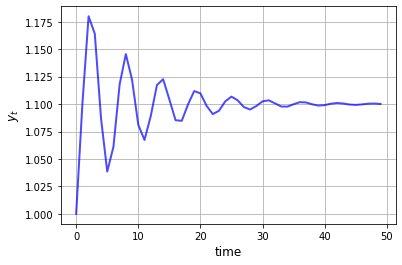

In [4]:
ϕ_0, ϕ_1, ϕ_2 = 1.1, 0.8, -0.8

A = [[1,     0,     0  ],
     [ϕ_0,   ϕ_1,   ϕ_2],
     [0,     1,     0  ]]

C = np.zeros((3, 1))
G = [0, 1, 0]

plot_lss(A, C, G)

Later you’ll be asked to recreate this figure.

#### Univariate Autoregressive Processes


<a id='index-3'></a>
We can use [(14.1)](#equation-st-space-rep) to represent the model


<a id='equation-eq-ar-rep'></a>
$$
y_{t+1} = \phi_1 y_{t} + \phi_2 y_{t-1} + \phi_3 y_{t-2} + \phi_4  y_{t-3} + \sigma w_{t+1} \tag{3}
$$

where $ \{w_t\} $ is IID and standard normal.

To put this in the linear state space format we take $ x_t = \begin{bmatrix} y_t & y_{t-1} &  y_{t-2} &  y_{t-3} \end{bmatrix}' $ and

$$
A =
\begin{bmatrix}
    \phi_1 & \phi_2 & \phi_3 & \phi_4 \\
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0
\end{bmatrix}
\qquad
C = \begin{bmatrix}
        \sigma \\
        0 \\
        0 \\
        0
    \end{bmatrix}
\qquad
 G = \begin{bmatrix}
         1 & 0  & 0 & 0
     \end{bmatrix}
$$

The matrix $ A $ has the form of the *companion matrix* to the vector
$ \begin{bmatrix}\phi_1 &  \phi_2 & \phi_3 & \phi_4 \end{bmatrix} $.

The next figure shows the dynamics of this process when

$$
\phi_1 = 0.5, \phi_2 = -0.2, \phi_3 = 0, \phi_4 = 0.5, \sigma = 0.2, y_0 = y_{-1} = y_{-2} =
y_{-3} = 1
$$


<a id='lss-uap-fig'></a>

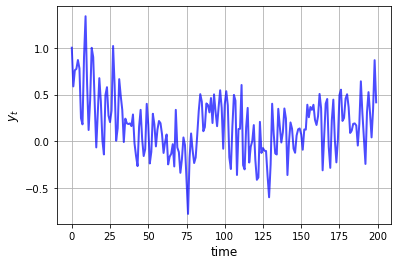

In [5]:
ϕ_1, ϕ_2, ϕ_3, ϕ_4 = 0.5, -0.2, 0, 0.5
σ = 0.2

A_1 = [[ϕ_1,   ϕ_2,   ϕ_3,   ϕ_4],
       [1,     0,     0,     0  ],
       [0,     1,     0,     0  ],
       [0,     0,     1,     0  ]]

C_1 = [[σ],
       [0],
       [0],
       [0]]

G_1 = [1, 0, 0, 0]

plot_lss(A_1, C_1, G_1, n=4, ts_length=200)

#### Vector Autoregressions


<a id='index-4'></a>
Now suppose that

- $ y_t $ is a $ k \times 1 $ vector  
- $ \phi_j $ is a $ k \times k $ matrix and  
- $ w_t $ is $ k \times 1 $  


Then [(14.3)](#equation-eq-ar-rep) is termed a *vector autoregression*.

To map this into [(14.1)](#equation-st-space-rep), we set

$$
x_t =
\begin{bmatrix}
     y_t \\
     y_{t-1} \\
     y_{t-2} \\
     y_{t-3}
 \end{bmatrix}
\quad
A =
\begin{bmatrix}
\phi_1 & \phi_2 & \phi_3 & \phi_4 \\
I & 0        & 0        & 0       \\
0 & I        & 0        & 0       \\
0 & 0        & I        & 0
\end{bmatrix}
\quad
C =
\begin{bmatrix}
     \sigma \\
     0 \\
     0 \\
     0
 \end{bmatrix}
\quad
G =
\begin{bmatrix}
     I & 0 & 0 & 0
 \end{bmatrix}
$$

where $ I $ is the $ k \times k $ identity matrix and $ \sigma $ is a $ k \times k $ matrix.

#### Seasonals


<a id='index-5'></a>
We can use [(14.1)](#equation-st-space-rep) to represent

1. the *deterministic seasonal* $ y_t = y_{t-4} $  
1. the *indeterministic seasonal* $ y_t = \phi_4 y_{t-4} + w_t $  


In fact, both are special cases of [(14.3)](#equation-eq-ar-rep).

With the deterministic seasonal, the transition matrix becomes

$$
A = \begin{bmatrix}
        0 & 0 & 0 & 1 \\
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0
    \end{bmatrix}
$$

It is easy to check that $ A^4 = I $, which implies that $ x_t $ is strictly periodic with period 4:<sup><a href=#foot1 id=foot1-link>[1]</a></sup>

$$
x_{t+4} = x_t
$$

Such an $ x_t $ process can be used to model deterministic seasonals in quarterly time series.

The *indeterministic* seasonal produces recurrent, but aperiodic, seasonal fluctuations.

#### Time Trends


<a id='index-6'></a>
The model $ y_t = a t + b $ is known as a *linear time trend*.

We can represent this model in the linear state space form by taking


<a id='equation-lss-ltt'></a>
$$
A
= \begin{bmatrix}
    1 & 1  \\
    0 & 1
  \end{bmatrix}
\qquad
C
= \begin{bmatrix}
        0 \\
        0
  \end{bmatrix}
\qquad
G
= \begin{bmatrix}
        a & b
  \end{bmatrix} \tag{4}
$$

and starting at initial condition $ x_0 = \begin{bmatrix} 0 & 1\end{bmatrix}' $.

In fact, it’s possible to use the state-space system to represent polynomial trends of any order.

For instance, we can represent the model $ y_t = a t^2 + bt + c $ in the linear state space form by taking

$$
A
= \begin{bmatrix}
    1 & 1 & 0 \\
    0 & 1 & 1 \\
    0 & 0 & 1
  \end{bmatrix}
\qquad
C
= \begin{bmatrix}
        0 \\
        0 \\
        0
  \end{bmatrix}
\qquad
G
= \begin{bmatrix}
        2a & a + b & c
  \end{bmatrix}
$$

and starting at initial condition $ x_0 = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}' $.

It follows that

$$
A^t =
\begin{bmatrix}
 1 & t & t(t-1)/2 \\
 0 & 1 & t \\
 0 & 0 & 1
\end{bmatrix}
$$

Then $ x_t^\prime = \begin{bmatrix} t(t-1)/2 &t & 1 \end{bmatrix} $. You can now confirm that $ y_t = G x_t $ has the correct form.

### Moving Average Representations


<a id='index-7'></a>
A nonrecursive expression for $ x_t $ as a function of
$ x_0, w_1, w_2, \ldots,  w_t $ can be found by using [(14.1)](#equation-st-space-rep) repeatedly to obtain


<a id='equation-eqob5'></a>
$$
\begin{aligned}
   x_t & = Ax_{t-1} + Cw_t \\
       & = A^2 x_{t-2} + ACw_{t-1} + Cw_t \nonumber \\
       & \qquad \vdots \nonumber \\
       & = \sum_{j=0}^{t-1} A^j Cw_{t-j}  + A^t x_0 \nonumber
\end{aligned} \tag{5}
$$

Representation [(14.5)](#equation-eqob5) is a  *moving average* representation.

It expresses $ \{x_t\} $ as a linear function of

1. current and past values of the  process $ \{w_t\} $ and  
1. the initial condition $ x_0 $  


As an example of a moving average representation, let the model be

$$
A
= \begin{bmatrix}
    1 & 1  \\
    0 & 1
  \end{bmatrix}
\qquad
C
= \begin{bmatrix}
        1 \\
        0
  \end{bmatrix}
$$

You will be able to show that $ A^t = \begin{bmatrix} 1 & t \cr 0 & 1 \end{bmatrix} $ and  $ A^j C = \begin{bmatrix} 1 & 0 \end{bmatrix}' $.

Substituting into the moving average representation [(14.5)](#equation-eqob5), we obtain

$$
x_{1t} = \sum_{j=0}^{t-1} w_{t-j} +
\begin{bmatrix}
 1 & t
\end{bmatrix}
x_0
$$

where $ x_{1t} $ is the first entry of $ x_t $.

The first term on the right is a cumulated sum of martingale differences and is therefore a [martingale](https://en.wikipedia.org/wiki/Martingale_%28probability_theory%29).

The second term is a translated linear function of time.

For this reason, $ x_{1t} $ is called a *martingale with drift*.

## Distributions and Moments


<a id='index-9'></a>

### Unconditional Moments

Using [(14.1)](#equation-st-space-rep), it’s easy to obtain expressions for the
(unconditional) means of $ x_t $ and $ y_t $.

We’ll explain what *unconditional* and *conditional* mean soon.

Letting $ \mu_t := \mathbb{E} [x_t] $ and using linearity of expectations, we
find that


<a id='equation-lss-mut-linear-models'></a>
$$
\mu_{t+1} = A \mu_t
\quad \text{with} \quad \mu_0 \text{ given} \tag{6}
$$

Here $ \mu_0 $ is a primitive given in [(14.1)](#equation-st-space-rep).

The variance-covariance matrix of $ x_t $ is $ \Sigma_t := \mathbb{E} [ (x_t - \mu_t) (x_t - \mu_t)'] $.

Using $ x_{t+1} - \mu_{t+1} = A (x_t - \mu_t) + C w_{t+1} $, we can
determine this matrix recursively via


<a id='equation-eqsigmalaw-linear-models'></a>
$$
\Sigma_{t+1}  = A \Sigma_t A' + C C'
\quad \text{with} \quad \Sigma_0 \text{ given} \tag{7}
$$

As with $ \mu_0 $, the matrix $ \Sigma_0 $ is a primitive given in [(14.1)](#equation-st-space-rep).

As a matter of terminology, we will sometimes call

- $ \mu_t $ the *unconditional mean*  of $ x_t $  
- $ \Sigma_t $ the *unconditional variance-covariance matrix*  of $ x_t $  


This is to distinguish $ \mu_t $ and $ \Sigma_t $ from related objects that use conditioning
information, to be defined below.

However, you should be aware that these “unconditional” moments do depend on
the initial distribution $ N(\mu_0, \Sigma_0) $.

#### Moments of the Observations

Using linearity of expectations again we have


<a id='equation-lss-umy'></a>
$$
\mathbb{E} [y_t] = \mathbb{E} [G x_t] = G \mu_t \tag{8}
$$

The variance-covariance matrix of $ y_t $ is easily shown to be


<a id='equation-lss-uvy'></a>
$$
\textrm{Var} [y_t] = \textrm{Var} [G x_t] = G \Sigma_t G' \tag{9}
$$

### Distributions


<a id='index-10'></a>
In general, knowing the mean and variance-covariance matrix of a random vector
is not quite as good as knowing the full distribution.

However, there are some situations where these moments alone tell us all we
need to know.

These are situations in which the mean vector and covariance matrix are **sufficient statistics** for the population distribution.

(Sufficient statistics form a list of objects that characterize a population distribution)

One such situation is when the vector in question is Gaussian (i.e., normally
distributed).

This is the case here, given

1. our Gaussian assumptions on the primitives  
1. the fact that normality is preserved under linear operations  


In fact, it’s [well-known](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation) that


<a id='equation-lss-glig'></a>
$$
u \sim N(\bar u, S)
\quad \text{and} \quad
v = a + B u
\implies
v \sim N(a + B \bar u, B S B') \tag{10}
$$

In particular, given our Gaussian assumptions on the primitives and the
linearity of [(14.1)](#equation-st-space-rep) we can see immediately that  both $ x_t $ and
$ y_t $ are  Gaussian for all $ t \geq 0 $ <sup><a href=#fn-ag id=fn-ag-link>[2]</a></sup>.

Since $ x_t $ is Gaussian, to find the distribution, all we need to do is
find its mean and variance-covariance matrix.

But in fact we’ve already done this, in [(14.6)](#equation-lss-mut-linear-models) and [(14.7)](#equation-eqsigmalaw-linear-models).

Letting $ \mu_t $ and $ \Sigma_t $ be as defined by these equations,
we have


<a id='equation-lss-mgs-x'></a>
$$
x_t \sim N(\mu_t, \Sigma_t) \tag{11}
$$

By similar reasoning combined with [(14.8)](#equation-lss-umy) and [(14.9)](#equation-lss-uvy),


<a id='equation-lss-mgs-y'></a>
$$
y_t \sim N(G \mu_t, G \Sigma_t G') \tag{12}
$$

### Ensemble Interpretations

How should we interpret the distributions defined by [(14.11)](#equation-lss-mgs-x)–[(14.12)](#equation-lss-mgs-y)?

Intuitively, the probabilities in a distribution correspond to relative frequencies in a large population drawn from that distribution.

Let’s apply this idea to our setting, focusing on the distribution of $ y_T $ for fixed $ T $.

We can generate independent draws of $ y_T $ by repeatedly simulating the
evolution of the system up to time $ T $, using an independent set of
shocks each time.

The next figure shows 20 simulations, producing 20 time series for $ \{y_t\} $, and hence 20 draws of $ y_T $.

The system in question is the univariate autoregressive model [(14.3)](#equation-eq-ar-rep).

The values of $ y_T $ are represented by black dots in the left-hand figure

In [6]:
def cross_section_plot(A,
                   C,
                   G,
                   T=20,                 # Set the time
                   ymin=-0.8,
                   ymax=1.25,
                   sample_size = 20,     # 20 observations/simulations
                   n=4):                 # The number of dimensions for the initial x0

    ar = LinearStateSpace(A, C, G, mu_0=np.ones(n))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for ax in axes:
        ax.grid(alpha=0.4)
        ax.set_ylim(ymin, ymax)

    ax = axes[0]
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('$y_t$', fontsize=12)
    ax.set_xlabel('time', fontsize=12)
    ax.vlines((T,), -1.5, 1.5)

    ax.set_xticks((T,))
    ax.set_xticklabels(('$T$',))

    sample = []
    for i in range(sample_size):
        rcolor = random.choice(('c', 'g', 'b', 'k'))
        x, y = ar.simulate(ts_length=T+15)
        y = y.flatten()
        ax.plot(y, color=rcolor, lw=1, alpha=0.5)
        ax.plot((T,), (y[T],), 'ko', alpha=0.5)
        sample.append(y[T])

    y = y.flatten()
    axes[1].set_ylim(ymin, ymax)
    axes[1].set_ylabel('$y_t$', fontsize=12)
    axes[1].set_xlabel('relative frequency', fontsize=12)
    axes[1].hist(sample, bins=16, density=True, orientation='horizontal', alpha=0.5)
    plt.show()

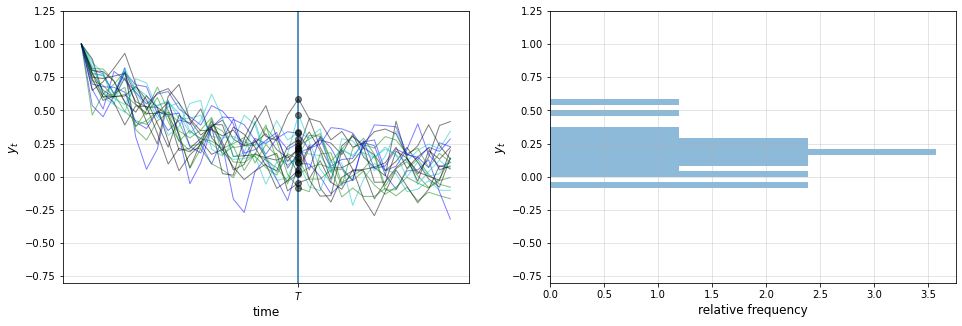

In [7]:
ϕ_1, ϕ_2, ϕ_3, ϕ_4 = 0.5, -0.2, 0, 0.5
σ = 0.1

A_2 = [[ϕ_1, ϕ_2, ϕ_3, ϕ_4],
       [1,     0,     0,     0],
       [0,     1,     0,     0],
       [0,     0,     1,     0]]

C_2 = [[σ], [0], [0], [0]]

G_2 = [1, 0, 0, 0]

cross_section_plot(A_2, C_2, G_2)

In the right-hand figure, these values are converted into a rotated histogram
that shows relative frequencies from our sample of 20 $ y_T $’s.

Here is another figure, this time with 100 observations

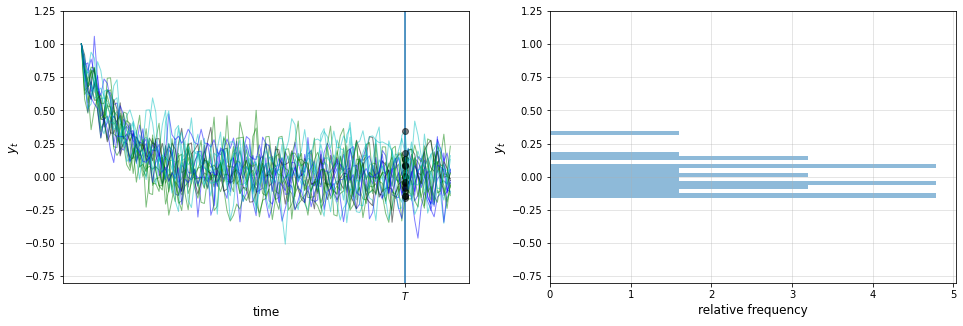

In [8]:
t = 100
cross_section_plot(A_2, C_2, G_2, T=t)

Let’s now try with 500,000 observations, showing only the histogram (without rotation)

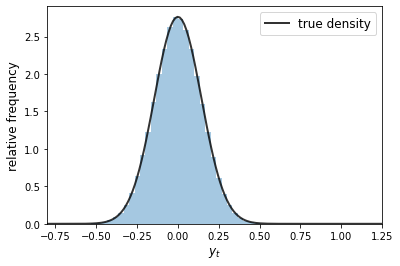

In [9]:
T = 100
ymin=-0.8
ymax=1.25
sample_size = 500_000

ar = LinearStateSpace(A_2, C_2, G_2, mu_0=np.ones(4))
fig, ax = plt.subplots()
x, y = ar.simulate(sample_size)
mu_x, mu_y, Sigma_x, Sigma_y = ar.stationary_distributions()
f_y = norm(loc=float(mu_y), scale=float(np.sqrt(Sigma_y)))
y = y.flatten()
ygrid = np.linspace(ymin, ymax, 150)

ax.hist(y, bins=50, density=True, alpha=0.4)
ax.plot(ygrid, f_y.pdf(ygrid), 'k-', lw=2, alpha=0.8, label=r'true density')
ax.set_xlim(ymin, ymax)
ax.set_xlabel('$y_t$', fontsize=12)
ax.set_ylabel('relative frequency', fontsize=12)
ax.legend(fontsize=12)
plt.show()

The black line is the population density of $ y_T $ calculated from [(14.12)](#equation-lss-mgs-y).

The histogram and population distribution are close, as expected.

By looking at the figures and experimenting with parameters, you will gain a
feel for how the population distribution depends on the model primitives [listed above](#lss-pgs), as intermediated by
the distribution’s sufficient statistics.

#### Ensemble Means

In the preceding figure, we approximated the population distribution of $ y_T $ by

1. generating $ I $ sample paths (i.e., time series) where $ I $ is a large number  
1. recording each observation $ y^i_T $  
1. histogramming this sample  


Just as the histogram approximates the population distribution, the *ensemble* or
*cross-sectional average*

$$
\bar y_T := \frac{1}{I} \sum_{i=1}^I y_T^i
$$

approximates the expectation $ \mathbb{E} [y_T] = G \mu_T $ (as implied by the law of large numbers).

Here’s a simulation comparing the ensemble averages and population means at time points $ t=0,\ldots,50 $.

The parameters are the same as for the preceding figures,
and the sample size is relatively small ($ I=20 $).


<a id='lss-em-fig'></a>

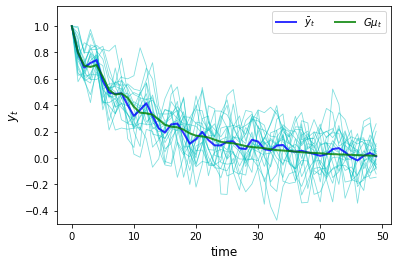

In [10]:
I = 20
T = 50
ymin = -0.5
ymax = 1.15

ar = LinearStateSpace(A_2, C_2, G_2, mu_0=np.ones(4))

fig, ax = plt.subplots()

ensemble_mean = np.zeros(T)
for i in range(I):
    x, y = ar.simulate(ts_length=T)
    y = y.flatten()
    ax.plot(y, 'c-', lw=0.8, alpha=0.5)
    ensemble_mean = ensemble_mean + y

ensemble_mean = ensemble_mean / I
ax.plot(ensemble_mean, color='b', lw=2, alpha=0.8, label='$\\bar y_t$')
m = ar.moment_sequence()

population_means = []
for t in range(T):
    μ_x, μ_y, Σ_x, Σ_y = next(m)
    population_means.append(float(μ_y))

ax.plot(population_means, color='g', lw=2, alpha=0.8, label='$G\mu_t$')
ax.set_ylim(ymin, ymax)
ax.set_xlabel('time', fontsize=12)
ax.set_ylabel('$y_t$', fontsize=12)
ax.legend(ncol=2)
plt.show()

The ensemble mean for $ x_t $ is

$$
\bar x_T := \frac{1}{I} \sum_{i=1}^I x_T^i \to \mu_T
\qquad (I \to \infty)
$$

The limit $ \mu_T $ is a  “long-run average”.

(By *long-run average* we mean the average for an infinite ($ I = \infty $)  number of sample $ x_T $’s)

Another application of the law of large numbers assures us that

$$
\frac{1}{I} \sum_{i=1}^I (x_T^i - \bar x_T) (x_T^i - \bar x_T)' \to \Sigma_T
\qquad (I \to \infty)
$$

### Joint Distributions

In the preceding discussion, we looked at the distributions of $ x_t $ and
$ y_t $ in isolation.

This gives us useful information but doesn’t allow us to answer questions like

- what’s the probability that $ x_t \geq 0 $ for all $ t $?  
- what’s the probability that the process $ \{y_t\} $ exceeds some value $ a $ before falling below $ b $?  
- etc., etc.  


Such questions concern the *joint distributions* of these sequences.

To compute the joint distribution of $ x_0, x_1, \ldots, x_T $, recall
that joint and conditional densities are linked by the rule

$$
p(x, y) = p(y \, | \, x) p(x)
\qquad \text{(joint }=\text{ conditional }\times\text{ marginal)}
$$

From this rule we get $ p(x_0, x_1) = p(x_1 \,|\, x_0) p(x_0) $.

The Markov property $ p(x_t \,|\, x_{t-1}, \ldots, x_0) =  p(x_t \,|\, x_{t-1}) $ and repeated applications of the preceding rule lead us to

$$
p(x_0, x_1, \ldots, x_T) =  p(x_0) \prod_{t=0}^{T-1} p(x_{t+1} \,|\, x_t)
$$

The marginal $ p(x_0) $ is just the primitive $ N(\mu_0, \Sigma_0) $.

In view of [(14.1)](#equation-st-space-rep), the conditional densities are

$$
p(x_{t+1} \,|\, x_t) = N(Ax_t, C C')
$$

#### Autocovariance Functions

An important object related to the joint distribution is the *autocovariance function*


<a id='equation-eqnautodeff'></a>
$$
\Sigma_{t+j, t} := \mathbb{E} [ (x_{t+j} - \mu_{t+j})(x_t - \mu_t)' ] \tag{13}
$$

Elementary calculations show that


<a id='equation-eqnautocov'></a>
$$
\Sigma_{t+j,t} = A^j \Sigma_t \tag{14}
$$

Notice that $ \Sigma_{t+j,t} $ in general depends on both $ j $, the gap between the two dates, and $ t $, the earlier date.

## Stationarity and Ergodicity


<a id='index-12'></a>
Stationarity and ergodicity are two properties  that, when they hold,  greatly aid analysis of linear state space models.

Let’s start with the intuition.

### Visualizing Stability

Let’s look at some more time series from the same model that we analyzed above.

This picture shows cross-sectional distributions for $ y $ at times
$ T, T', T'' $

In [11]:
def cross_plot(A,
            C,
            G,
            steady_state='False',
            T0 = 10,
            T1 = 50,
            T2 = 75,
            T4 = 100):

    ar = LinearStateSpace(A, C, G, mu_0=np.ones(4))

    if steady_state == 'True':
        μ_x, μ_y, Σ_x, Σ_y = ar.stationary_distributions()
        ar_state = LinearStateSpace(A, C, G, mu_0=μ_x, Sigma_0=Σ_x)

    ymin, ymax = -0.6, 0.6
    fig, ax = plt.subplots()
    ax.grid(alpha=0.4)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('$y_t$', fontsize=12)
    ax.set_xlabel('$time$', fontsize=12)

    ax.vlines((T0, T1, T2), -1.5, 1.5)
    ax.set_xticks((T0, T1, T2))
    ax.set_xticklabels(("$T$", "$T'$", "$T''$"), fontsize=12)
    for i in range(80):
        rcolor = random.choice(('c', 'g', 'b'))

        if steady_state == 'True':
            x, y = ar_state.simulate(ts_length=T4)
        else:
            x, y = ar.simulate(ts_length=T4)

        y = y.flatten()
        ax.plot(y, color=rcolor, lw=0.8, alpha=0.5)
        ax.plot((T0, T1, T2), (y[T0], y[T1], y[T2],), 'ko', alpha=0.5)
    plt.show()

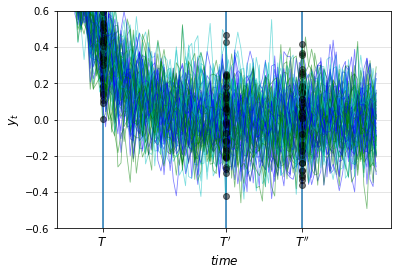

In [12]:
cross_plot(A_2, C_2, G_2)

Note how the time series “settle down” in the sense that the distributions at
$ T' $ and $ T'' $ are relatively similar to each other — but unlike
the distribution at $ T $.

Apparently, the distributions of $ y_t $  converge to a fixed long-run
distribution as $ t \to \infty $.

When such a distribution exists it is called a *stationary distribution*.

### Stationary Distributions

In our setting, a distribution $ \psi_{\infty} $ is said to be *stationary* for $ x_t $ if

$$
x_t \sim \psi_{\infty}
\quad \text{and} \quad
x_{t+1} = A x_t + C w_{t+1}
\quad \implies \quad
x_{t+1} \sim \psi_{\infty}
$$

Since

1. in the present case, all distributions are Gaussian  
1. a Gaussian distribution is pinned down by its mean and variance-covariance matrix  


we can restate the definition as follows: $ \psi_{\infty} $ is stationary for $ x_t $ if

$$
\psi_{\infty}
= N(\mu_{\infty}, \Sigma_{\infty})
$$

where $ \mu_{\infty} $ and $ \Sigma_{\infty} $ are fixed points of [(14.6)](#equation-lss-mut-linear-models) and [(14.7)](#equation-eqsigmalaw-linear-models) respectively.

### Covariance Stationary Processes

Let’s see what happens to the preceding figure if we start $ x_0 $ at the stationary distribution.


<a id='lss-s-fig'></a>

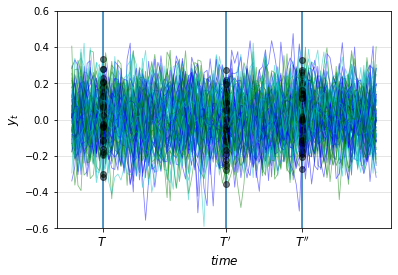

In [13]:
cross_plot(A_2, C_2, G_2, steady_state='True')

Now the  differences in the observed distributions at $ T, T' $ and $ T'' $ come entirely from random fluctuations due to the finite sample size.

By

- our choosing $ x_0 \sim N(\mu_{\infty}, \Sigma_{\infty}) $  
- the definitions of $ \mu_{\infty} $ and $ \Sigma_{\infty} $ as fixed points of [(14.6)](#equation-lss-mut-linear-models) and [(14.7)](#equation-eqsigmalaw-linear-models) respectively  


we’ve ensured that

$$
\mu_t = \mu_{\infty}
\quad \text{and} \quad
\Sigma_t = \Sigma_{\infty}
\quad \text{for all } t
$$

Moreover, in view of [(14.14)](#equation-eqnautocov), the autocovariance function takes the form $ \Sigma_{t+j,t} = A^j \Sigma_\infty $, which depends on $ j $ but not on $ t $.

This motivates the following definition.

A  process $ \{x_t\} $ is said to be *covariance stationary* if

- both $ \mu_t $ and $ \Sigma_t $ are constant in $ t $  
- $ \Sigma_{t+j,t} $ depends on the time gap $ j $ but not on time $ t $  


In our setting, $ \{x_t\} $ will be covariance stationary if $ \mu_0, \Sigma_0, A, C $  assume values that  imply that none of $ \mu_t, \Sigma_t, \Sigma_{t+j,t} $ depends on $ t $.

### Conditions for Stationarity

#### The Globally Stable Case

The difference equation $ \mu_{t+1} = A \mu_t $ is known to have *unique*
fixed point $ \mu_{\infty} = 0 $ if all eigenvalues of $ A $ have moduli strictly less than unity.

That is, if  `(np.absolute(np.linalg.eigvals(A)) < 1).all() == True`.

The difference equation [(14.7)](#equation-eqsigmalaw-linear-models) also has a unique fixed point in this case, and, moreover

$$
\mu_t \to \mu_{\infty} = 0
\quad \text{and} \quad
\Sigma_t \to \Sigma_{\infty}
\quad \text{as} \quad t \to \infty
$$

regardless of the initial conditions $ \mu_0 $ and $ \Sigma_0 $.

However, global stability is more than we need for stationary solutions, and often more than we want.

To illustrate, consider [our second order difference equation example](#lss-sode).

Here the state is $ x_t = \begin{bmatrix} 1 & y_t & y_{t-1} \end{bmatrix}' $.

Because of the constant first component in the state vector, we will never have $ \mu_t \to 0 $.

How can we find stationary solutions that respect a constant state component?

#### Processes with a Constant State Component

To investigate such a process, suppose that $ A $ and $ C $ take the
form

$$
A
 = \begin{bmatrix}
    A_1 & a \\
    0 & 1
\end{bmatrix}
 \qquad
 C  = \begin{bmatrix}
     C_1 \\
     0
\end{bmatrix}
$$

where

- $ A_1 $ is an $ (n-1) \times (n-1) $ matrix  
- $ a $ is an $ (n-1) \times 1 $ column vector  


Let $ x_t = \begin{bmatrix} x_{1t}' & 1 \end{bmatrix}' $ where $ x_{1t} $ is $ (n-1) \times 1 $.

It follows  that

$$
\begin{aligned}
x_{1,t+1} & = A_1 x_{1t} + a + C_1 w_{t+1}
\end{aligned}
$$

Let $ \mu_{1t} = \mathbb{E} [x_{1t}] $ and take expectations on both sides of this expression to get


<a id='equation-eqob29'></a>
$$
\mu_{1,t+1} = A_1 \mu_{1,t} + a \tag{15}
$$

Assume now that the moduli of the eigenvalues of $ A_1 $ are all strictly less than one.

Then [(14.15)](#equation-eqob29) has a unique stationary solution, namely,

$$
\mu_{1\infty} = (I-A_1)^{-1} a
$$

The stationary value of $ \mu_t $ itself is then $ \mu_\infty := \begin{bmatrix}
\mu_{1\infty}' & 1 \end{bmatrix}' $.

The stationary values of $ \Sigma_t $ and $ \Sigma_{t+j,t} $ satisfy


<a id='equation-eqnsigmainf'></a>
$$
\begin{aligned}
\Sigma_\infty  & = A \Sigma_\infty A' + C C' \\
\Sigma_{t+j,t} & = A^j \Sigma_\infty \nonumber
\end{aligned} \tag{16}
$$

Notice that here $ \Sigma_{t+j,t} $ depends on the time gap $ j $ but not on calendar time $ t $.

In conclusion, if

- $ x_0 \sim N(\mu_{\infty}, \Sigma_{\infty}) $ and  
- the moduli of the eigenvalues of $ A_1 $ are all strictly less than unity  


then the $ \{x_t\} $ process is covariance stationary, with constant state
component.

>**Note**
>
>If the eigenvalues of $ A_1 $ are less than unity in modulus, then
(a) starting from any initial value, the mean and variance-covariance
matrix both converge to their stationary values; and (b)
iterations on [(14.7)](#equation-eqsigmalaw-linear-models) converge to the fixed point of the *discrete
Lyapunov equation* in the first line of [(14.16)](#equation-eqnsigmainf).

### Ergodicity

Let’s suppose that we’re working with a covariance stationary process.

In this case, we know that the ensemble mean will converge to $ \mu_{\infty} $ as the sample size $ I $ approaches infinity.

#### Averages over Time

Ensemble averages across simulations are interesting theoretically, but in real life, we usually observe only a *single* realization $ \{x_t, y_t\}_{t=0}^T $.

So now let’s take a single realization and form the time-series averages

$$
\bar x := \frac{1}{T} \sum_{t=1}^T x_t
\quad \text{and} \quad
\bar y := \frac{1}{T} \sum_{t=1}^T y_t
$$

Do these time series averages converge to something interpretable in terms of our basic state-space representation?

The answer depends on something called *ergodicity*.

Ergodicity is the property that time series and ensemble averages coincide.

More formally, ergodicity implies that time series sample averages converge to their
expectation under the stationary distribution.

In particular,

- $ \frac{1}{T} \sum_{t=1}^T x_t \to \mu_{\infty} $  
- $ \frac{1}{T} \sum_{t=1}^T (x_t -\bar x_T) (x_t - \bar x_T)' \to \Sigma_\infty $  
- $ \frac{1}{T} \sum_{t=1}^T (x_{t+j} -\bar x_T) (x_t - \bar x_T)' \to A^j \Sigma_\infty $  


In our linear Gaussian setting, any covariance stationary process is also ergodic.

## Noisy Observations

In some settings, the observation equation $ y_t = Gx_t $ is modified to
include an error term.

Often this error term represents the idea that the true state can only be
observed imperfectly.

To include an error term in the observation we introduce

- An IID sequence of $ \ell \times 1 $ random vectors $ v_t \sim N(0,I) $.  
- A $ k \times \ell $ matrix $ H $.  


and extend the linear state-space system to


<a id='equation-st-space-rep-noisy'></a>
$$
\begin{aligned}
    x_{t+1} & =  A x_t + C w_{t+1}   \\
    y_t &  =  G x_t + H v_t \nonumber \\
    x_0 & \sim N(\mu_0, \Sigma_0) \nonumber
\end{aligned} \tag{17}
$$

The sequence $ \{v_t\} $ is assumed to be independent of $ \{w_t\} $.

The process $ \{x_t\} $ is not modified by noise in the observation
equation and its moments, distributions and stability properties remain the same.

The unconditional moments of $ y_t $ from [(14.8)](#equation-lss-umy) and [(14.9)](#equation-lss-uvy)
now become


<a id='equation-lss-umy-2'></a>
$$
\mathbb{E} [y_t] = \mathbb{E} [G x_t + H v_t] = G \mu_t \tag{18}
$$

The variance-covariance matrix of $ y_t $ is easily shown to be


<a id='equation-lss-uvy-2'></a>
$$
\textrm{Var} [y_t] = \textrm{Var} [G x_t + H v_t] = G \Sigma_t G' + HH' \tag{19}
$$

The distribution of $ y_t $ is therefore

$$
y_t \sim N(G \mu_t, G \Sigma_t G' + HH')
$$

## Prediction


<a id='index-13'></a>
The theory of prediction for linear state space systems is elegant and
simple.


<a id='ff-cm'></a>

### Forecasting Formulas – Conditional Means

The natural way to predict variables is to use conditional distributions.

For example, the optimal forecast of $ x_{t+1} $ given information known at time $ t $ is

$$
\mathbb{E}_t [x_{t+1}] := \mathbb{E} [x_{t+1} \mid x_t, x_{t-1}, \ldots, x_0 ] = Ax_t
$$

The right-hand side follows from $ x_{t+1} = A x_t + C w_{t+1} $ and the
fact that $ w_{t+1} $ is zero mean and independent of $ x_t, x_{t-1}, \ldots, x_0 $.

That $ \mathbb{E}_t [x_{t+1}] = \mathbb{E}[x_{t+1} \mid x_t] $ is an implication of $ \{x_t\} $ having the *Markov property*.

The one-step-ahead forecast error is

$$
x_{t+1} - \mathbb{E}_t [x_{t+1}] = Cw_{t+1}
$$

The covariance matrix of the forecast error is

$$
\mathbb{E} [ (x_{t+1} - \mathbb{E}_t [ x_{t+1}] ) (x_{t+1} - \mathbb{E}_t [ x_{t+1}])'] = CC'
$$

More generally, we’d like to compute the $ j $-step ahead forecasts $ \mathbb{E}_t [x_{t+j}] $ and $ \mathbb{E}_t [y_{t+j}] $.

With a bit of algebra, we obtain

$$
x_{t+j} = A^j x_t + A^{j-1} C w_{t+1} + A^{j-2} C w_{t+2} +
\cdots + A^0 C w_{t+j}
$$

In view of the IID property, current and past state values provide no information about future values of the shock.

Hence $ \mathbb{E}_t[w_{t+k}] = \mathbb{E}[w_{t+k}] = 0 $.

It now follows from linearity of expectations that the $ j $-step ahead forecast of $ x $ is

$$
\mathbb{E}_t [x_{t+j}] = A^j x_t
$$

The $ j $-step ahead forecast of $ y $ is therefore

$$
\mathbb{E}_t [y_{t+j}]
= \mathbb{E}_t [G x_{t+j} + H v_{t+j}]
= G A^j x_t
$$

### Covariance of Prediction Errors

It is useful to obtain the covariance matrix of the vector of  $ j $-step-ahead prediction errors


<a id='equation-eqob8'></a>
$$
x_{t+j} - \mathbb{E}_t [ x_{t+j}] = \sum^{j-1}_{s=0} A^s C w_{t-s+j} \tag{20}
$$

Evidently,


<a id='equation-eqob9a'></a>
$$
V_j := \mathbb{E}_t [ (x_{t+j} - \mathbb{E}_t [x_{t+j}] ) (x_{t+j} - \mathbb{E}_t [x_{t+j}] )^\prime ] =   \sum^{j-1}_{k=0} A^k C C^\prime A^{k^\prime} \tag{21}
$$

$ V_j $ defined in [(14.21)](#equation-eqob9a) can be calculated recursively via $ V_1 = CC' $ and


<a id='equation-eqob9b'></a>
$$
V_j = CC^\prime + A V_{j-1} A^\prime, \quad j \geq 2 \tag{22}
$$

$ V_j $ is the *conditional covariance matrix* of the errors in forecasting
$ x_{t+j} $, conditioned on time $ t $ information $ x_t $.

Under particular conditions, $ V_j $ converges to


<a id='equation-eqob10'></a>
$$
V_\infty = CC' + A V_\infty A' \tag{23}
$$

Equation [(14.23)](#equation-eqob10) is an example of a *discrete Lyapunov* equation in the covariance matrix $ V_\infty $.

A sufficient condition for $ V_j $ to converge is that the eigenvalues of $ A $ be strictly less than one in modulus.

Weaker sufficient conditions for convergence  associate eigenvalues equaling or exceeding one in modulus with elements of $ C $ that equal $ 0 $.


<a id='lm-fgs'></a>

## Code

Our preceding simulations and calculations are based on code in
the file [lss.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) from the [QuantEcon.py](http://quantecon.org/quantecon-py) package.

The code implements a class for handling linear state space models (simulations, calculating moments, etc.).

One Python construct you might not be familiar with is the use of a generator function in the method `moment_sequence()`.

Go back and [read the relevant documentation](https://python-programming.quantecon.org/python_advanced_features.html#generators) if you’ve forgotten how generator functions work.

Examples of usage are given in the solutions to the exercises.

## Exercises


<a id='lss-ex1'></a>

### Exercise 1

In several contexts, we want to compute forecasts of  geometric sums of future random variables governed by the linear state-space system [(14.1)](#equation-st-space-rep).

We want the following objects

- Forecast of a geometric sum of future $ x $’s, or $ \mathbb{E}_t \left[ \sum_{j=0}^\infty \beta^j x_{t+j} \right] $.  
- Forecast of a geometric sum of future $ y $’s, or $ \mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j y_{t+j} \right] $.  


These objects are important components of some famous and  interesting dynamic models.

For example,

- if $ \{y_t\} $ is a stream of dividends, then $ \mathbb{E} \left[\sum_{j=0}^\infty \beta^j y_{t+j} | x_t \right] $ is a model of a stock price  
- if $ \{y_t\} $ is  the money supply, then $ \mathbb{E} \left[\sum_{j=0}^\infty \beta^j y_{t+j} | x_t \right] $ is a  model of the price level  


Show that:

$$
\mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j x_{t+j} \right] = [I - \beta A]^{-1} x_t
$$

and

$$
\mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j y_{t+j} \right] = G[I - \beta A]^{-1} x_t
$$

what must the modulus for every eigenvalue of $ A $ be less than?

## Solutions

### Exercise 1

Suppose that every eigenvalue of $ A $ has modulus strictly less than $ \frac{1}{\beta} $.

It [then follows](https://python.quantecon.org/linear_algebra.html#la-neumann-remarks) that $ I + \beta A + \beta^2 A^2 + \cdots = \left[I - \beta A \right]^{-1} $.

This leads to our formulas:

- Forecast of a geometric sum of future $ x $’s  


$$
\mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j x_{t+j} \right]
= [I + \beta A + \beta^2 A^2 + \cdots \ ] x_t = [I - \beta A]^{-1} x_t
$$

- Forecast of a geometric sum of future $ y $’s  


$$
\mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j y_{t+j} \right]
= G [I + \beta A + \beta^2 A^2 + \cdots \ ] x_t
= G[I - \beta A]^{-1} x_t
$$

<p><a id=foot1 href=#foot1-link><strong>[1]</strong></a> The eigenvalues of $ A $ are $ (1,-1, i,-i) $.

<p><a id=fn-ag href=#fn-ag-link><strong>[2]</strong></a> The correct way to argue this is by induction.  Suppose that
$ x_t $ is Gaussian.  Then [(14.1)](#equation-st-space-rep) and
[(14.10)](#equation-lss-glig) imply that $ x_{t+1} $ is Gaussian.  Since $ x_0 $
is assumed to be Gaussian, it follows that every $ x_t $ is Gaussian.
Evidently, this implies that each $ y_t $ is Gaussian.